In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from CPT import CPT, read_file, pprint_tree

In [2]:
datafile = './data/train.csv'
%time data = read_file(datafile, id_col='ID', line_num_col='LINE_NB', code_col='CODE', require_sorting=False)

Wall time: 19.3 s


In [3]:
print("total nb of sequences %i" % len(data))

total nb of sequences 44358


In [4]:
data[:10]

[['UL', 'ULV'],
 ['PX9', 'L5TG', 'L5TG'],
 ['TP', 'TP', 'TP', 'TP', 'TP', 'TP', 'TP', 'TP', 'TP'],
 ['U4', '6ML'],
 ['PX9', 'RVX9L', 'L5TG', 'L5TG'],
 ['LYJ', 'LYJ', 'LYJ', 'PX9', 'LYJ', 'GL9L', 'L5TG', 'L5TG'],
 ['3PX', 'V5TG'],
 ['VPX', 'VPX'],
 ['PX9', 'RVX9L', 'L5TG', 'L5TG'],
 ['ZZ4', '4LV']]

In [5]:
# Split train and test

sample_size = 500

seq = pd.DataFrame({'seq':data})
test_sample = seq.sample(n=sample_size)
data_test = test_sample['seq'].to_list()
train = seq[~seq.index.isin(test_sample.index)]
data_train = train['seq'].to_list()

In [6]:
# Instantiate Model
my_cpt = CPT()

In [7]:
# Train Model
%time my_cpt.train(data, max_seq_length=20)
my_cpt.prune(2)

Wall time: 503 ms


In [8]:
# Predict

nb_of_preds = 3
%time result_with_score = my_cpt.predict(data_test, n=nb_of_preds, k=10, p=1, coef=2.5)

Wall time: 8.07 s


In [9]:
result = [[k for k,v in pred] for pred in result_with_score]
result_first = [x[0] for x in result]

ndf = pd.DataFrame(data={'Prefix':[l[:-1] for l in data_test],'Real':[l[-1:][0] for l in data_test],'Pred':result_first,'Full_Pred':result,'Full_Pred_Score':result_with_score})

In [10]:
ndf.head()

,Prefix,Real,Pred,Full_Pred,Full_Pred_Score
0,[86X],86X,86X,"[86X, 8QX, E6U]","[(86X, 0.73), (8QX, 0.16), (E6U, 0.11)]"
1,[86X],86X,86X,"[86X, 8QX, E6U]","[(86X, 0.73), (8QX, 0.16), (E6U, 0.11)]"
2,"[UL, ULV]",L9V,VPX,"[VPX, ULV, E6X]","[(VPX, 1.0), (ULV, 0.0), (E6X, 0.0)]"
3,"[ZVX, UVX]",UVX,GMJ,"[GMJ, UVX, XJ8]","[(GMJ, 1.0), (UVX, 0.0), (XJ8, 0.0)]"
4,[TK6],TK6,TK6,"[TK6, AG9, A6G]","[(TK6, 0.73), (AG9, 0.14), (A6G, 0.14)]"


In [11]:
# % of predictions were the first result is the good one

accuracy = (ndf['Real']==ndf['Pred']).sum()/ndf.shape[0] * 100
print("%.2f %% of good predictions !" % accuracy)

44.80 % of good predictions !


In [12]:
# % of predictions were result is in the n first predictions

ok = []
for idx,row in ndf.iterrows():
#     print(row.Real in row.Full_Pred)
    if row.Real in row.Full_Pred:
        ok.append(idx)
        
accuracy = len(ok)/ndf.shape[0] * 100
print("%.2f %% in the %s first predictions" % (accuracy,nb_of_preds))

64.00 % in the 3 first predictions


In [13]:
# % of predictions with no result

no_answer = (ndf['Pred']=='--NO-RESULT--').sum()/ndf.shape[0] * 100
print("%.2f %%  without answer" % no_answer)

1.20 %  without answer


In [14]:
# example of good predictions

ndf[(ndf['Real']==ndf['Pred'])==True][:5]

,Prefix,Real,Pred,Full_Pred,Full_Pred_Score
0,[86X],86X,86X,"[86X, 8QX, E6U]","[(86X, 0.73), (8QX, 0.16), (E6U, 0.11)]"
1,[86X],86X,86X,"[86X, 8QX, E6U]","[(86X, 0.73), (8QX, 0.16), (E6U, 0.11)]"
4,[TK6],TK6,TK6,"[TK6, AG9, A6G]","[(TK6, 0.73), (AG9, 0.14), (A6G, 0.14)]"
6,[8QX],8QX,8QX,"[8QX, 86X, E6U]","[(8QX, 0.88), (86X, 0.07), (E6U, 0.05)]"
10,[VPX],VPX,VPX,"[VPX, 86X, 9X9]","[(VPX, 0.99), (86X, 0.01), (9X9, 0.01)]"


In [15]:
# example of bad predictions

ndf[(ndf['Real']==ndf['Pred'])==False][:5]

,Prefix,Real,Pred,Full_Pred,Full_Pred_Score
2,"[UL, ULV]",L9V,VPX,"[VPX, ULV, E6X]","[(VPX, 1.0), (ULV, 0.0), (E6X, 0.0)]"
3,"[ZVX, UVX]",UVX,GMJ,"[GMJ, UVX, XJ8]","[(GMJ, 1.0), (UVX, 0.0), (XJ8, 0.0)]"
5,[4K],6V,Z8,"[Z8, VZ8, 4EV]","[(Z8, 1.0), (VZ8, 0.0), (4EV, 0.0)]"
7,[VPX],5G,VPX,"[VPX, 5G, UVX]","[(VPX, 0.99), (5G, 0.01), (UVX, 0.01)]"
8,"[UL, ULV]",L9V,VPX,"[VPX, ULV, E6X]","[(VPX, 1.0), (ULV, 0.0), (E6X, 0.0)]"


In [16]:
def conf_matr_plot(ytest,ypred,threshold=0,normalize=True,show_diag=True,show_alls=False):
    conf_matr = pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)
    
    # Filter rows < threshold * global_total
    n_threshold = threshold * conf_matr.loc['All','All']
    conf_matr = conf_matr.loc[(conf_matr['All']>n_threshold),:]  # keep rows > threshold
    
    # Normalize
    if normalize:
        conf_matr = conf_matr.div(conf_matr['All'],axis=0)  # Normalize matrix vs rowsum
#         conf_matr_norm = conf_matr_filter.div(conf_matr_filter.loc['All','All'],axis=0)  # Normalize matrix vs total
    
    # Remove diagonal elements (good predictions)
    if not show_diag:
        for idx, row in conf_matr.iterrows():  
            row.loc[row.name]=0
    
    # Remove columns <= threshold
    drop_col = []
    for col,seri in conf_matr.iteritems(): 
        if seri[seri.index!='All'].sum()<=threshold:
            drop_col.append(col)
    conf_matr = conf_matr.drop(columns=drop_col)
    
    # Drop totals
    if not show_alls:
        conf_matr = conf_matr.drop(columns='All')  # Drop column 'All' always = 1
        conf_matr = conf_matr[conf_matr.index != "All"]  # Drop Row 'All'
    
    conf_matr = round(conf_matr * 100,1)
    
    return conf_matr

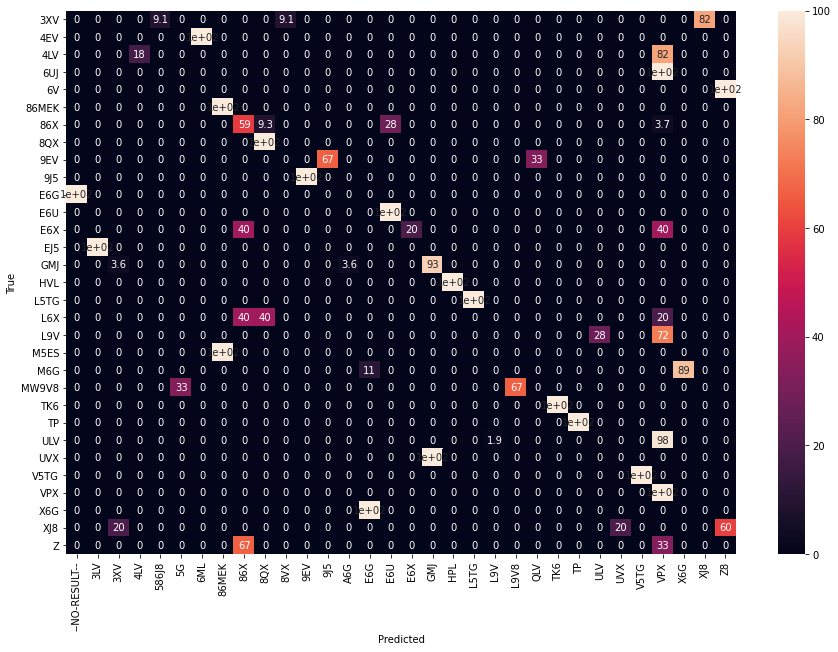

In [17]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.heatmap(conf_matr_plot(ndf['Real'],ndf['Pred'],threshold=0.005,normalize=True,show_diag=True, show_alls=False),annot=True);

In [18]:
# Show Tree
pprint_tree(my_cpt.root_node)

└─ None = 129358
   ├─ UL = 7210
   │  ├─ ULV = 1564
   │  │  ├─ L9V = 1439
   │  │  │  ├─ VPX = 115
   │  │  │  ├─ QLV = 5
   │  │  │  ├─ E6X = 7
   │  │  │  ├─ 3LV = 6
   │  │  │  ├─ QPV = 3
   │  │  │  ├─ ELV = 5
   │  │  │  ├─ 5G = 6
   │  │  │  └─ L6X = 2
   │  │  └─ VPX = 6
   │  │     ├─ VPX = 2
   │  │     └─ L9V = 2
   │  ├─ L9V = 4492
   │  │  ├─ ULV = 4376
   │  │  │  ├─ UL = 5
   │  │  │  │  └─ L9V = 5
   │  │  │  │     └─ ULV = 5
   │  │  │  ├─ VPX = 284
   │  │  │  ├─ ELV = 14
   │  │  │  ├─ 3LV = 12
   │  │  │  ├─ E6X = 28
   │  │  │  ├─ L6X = 15
   │  │  │  ├─ QLV = 5
   │  │  │  ├─ QPV = 5
   │  │  │  └─ 86X = 3
   │  │  ├─ 3LV = 2
   │  │  └─ VPX = 12
   │  ├─ 9EV = 444
   │  │  ├─ EJ5 = 176
   │  │  │  └─ 3LV = 4
   │  │  └─ 9J5 = 268
   │  ├─ ELV = 10
   │  │  └─ L9V = 2
   │  │     └─ ULV = 2
   │  ├─ 9J5 = 281
   │  │  └─ 9EV = 195
   │  ├─ EJ5 = 190
   │  │  └─ 9EV = 89
   │  │     └─ QLV = 2
   │  ├─ VPX = 143
   │  │  ├─ L9V = 12
   │  │  │  └─ ULV = 12
   │  │